In [14]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time

In [66]:
def extract_delta_color(pdf: pd.DataFrame, smooth_by:float):
    """ Extract last g-r for each object in a pandas DataFrame
    
    Modified from Fink https://github.com/astrolabsoftware/fink-science-portal/blob/a4398aa8af9d41d4f385489a32bba190e6c8f70e/apps/utils.py#L550
    - grouping values to a given mjd interval
    - rate
    
    Parameters
    ----------
    pdf: pandas DataFrame
        DataFrame containing magnitude, mjd, filters
        Filter band, as integer. g: 1, i: 2
    Returns
    ----------
    dmag: np.array
        Vector containing delta(mag) for the filter `filter_`. Last measurement
        shown first.
    rate: np.array
        Vector containing delta(mag)/delta(time) for the filter `filter_`.
        Last measurement shown first.
    """
    
    # easier to deal if the output is DataFrame
    df_out = pd.DataFrame()
    
    # extract unique objects
#     ids, indices = np.unique(pdf['id'].values, return_index=True)
#     ids = [pdf['id'].values[index] for index in sorted(indices)]

    # loop over objects
    dmag = []
    rate = []
    dmag_mjd = []
#     for id_ in ids:
#     maskId = pdf['id'] == id_
#     subpdf = pdf[maskId]

    subpdf = pdf
    subpdf['mjd'] = subpdf['mjd'].astype(float)
    subpdf = subpdf.sort_values('mjd', ascending=False)

    mag = subpdf['m'].values

    vec_ = np.zeros_like(mag)
    rate_ = np.zeros_like(mag)

    # Diff mag
    # smoothing for better estimates
    # TO DO: add robot scores
    min_mjd = float(int(subpdf.mjd.min()))
    max_mjd = float(int(subpdf.mjd.max()))
    print(min_mjd,max_mjd)
    bins = np.arange(min_mjd, max_mjd, smooth_by)
    df_grouped = subpdf.groupby(np.digitize(subpdf.mjd, bins)).median()
    mag_grouped = df_grouped['m']
    mjd_grouped = df_grouped['mjd']
    dmag_ = mag_grouped.diff(periods=-1).values
    dmag_mjd_ = mjd_grouped
#     print(len(df_grouped['m']),len(pdf))

    # Rate by day
    bins = np.arange(min_mjd, max_mjd, 1)
    df_grouped_byday = subpdf.groupby(np.digitize(subpdf.mjd, bins)).median()
    mag_grouped_byday = df_grouped_byday['m']
    rate_ = mag_grouped_byday.diff(periods=-1).values


    # temp diff jd
#         djd_ = subpdf['mjd'].diff(periods=-1).values

    # color rate
#         rate_ = dmag_ / djd_
    dmag = np.concatenate([dmag, dmag_])
    dmag_mjd = np.concatenate([dmag_mjd, dmag_mjd_])
    rate = np.concatenate([rate, rate_])

    # replace nans by 0.0
    dmag = np.nan_to_num(dmag)
    rate = np.nan_to_num(rate)

    return dmag_mjd, dmag, dcolor, rate, 

In [37]:
inpath = "./CDFS_60.20"
list_files = glob.glob(f"{inpath}/*.forced.difflc.txt")
df_tmp = Table.read(list_files[0], format="ascii").to_pandas()

In [38]:
t = Time(df_tmp['dateobs'].to_list(), format='isot', scale='utc')

In [46]:
df_tmp['mjd']=t.mjd


In [64]:
df_tmp = df_tmp[df_tmp['m']!='-']
df_tmp['m'] = df_tmp['m'].astype(np.float)
df_tmp =df_tmp[~df_tmp['m'].isna()]

<ipython-input-64-a88042c36b76>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_tmp['m'] = df_tmp['m'].astype(np.float)
<ipython-input-64-a88042c36b76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['m'] = df_tmp['m'].astype(np.float)


In [76]:
smoothed_dmag_mjd, smoothed_dmag, dayrate_dmag = extract_delta_color(df_tmp,smooth_by=0.01)

59478.0 59571.0


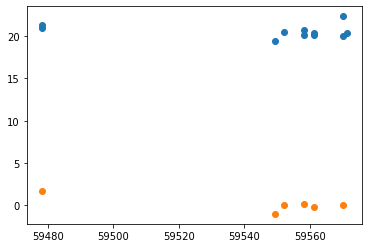

In [75]:
plt.scatter(df_tmp.mjd,df_tmp.m)
plt.scatter(smoothed_dmag_mjd,smoothed_dmag)

,MJD,dateobs,photcode,filt,flux_c,dflux_c,type,chisqr,ZPTMAG_c,m,dm,ra,dec,cmpfile,tmpl,mjd
0,59478.29006,2021-09-21T06:57:41.184,20500.0,r,16741.71,397.01,17.0,141.02,31.4717,20.912,0.026,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.r.59478.29006.N007.stk_r.594...,CDFS.r.59475.30439.N004.stk_60.sw.fits,59478.29006
1,59549.26080,2021-12-01T06:15:33.120,20500.0,r,63718.44,928.06,17.0,219.45,31.4717,19.461,0.016,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.r.59549.26080.N001.stk_r.594...,CDFS.r.59475.30439.N004.stk_60.sw.fits,59549.26080
2,59552.25715,2021-12-04T06:10:17.760,20500.0,r,25147.05,740.94,17.0,2.97,31.4717,20.470,0.032,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.r.59552.25715.N001.stk_r.594...,CDFS.r.59475.30439.N004.stk_60.sw.fits,59552.25715
3,59558.23423,2021-12-10T05:37:17.472,20500.0,r,20837.10,732.45,17.0,51.98,31.4717,20.675,0.038,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.r.59558.23423.N001.stk_r.594...,CDFS.r.59475.30439.N004.stk_60.sw.fits,59558.23423
4,59561.24012,2021-12-13T05:45:46.368,20500.0,r,28714.88,805.54,17.0,1.90,31.4717,20.326,0.030,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.r.59561.24012.N001.stk_r.594...,CDFS.r.59475.30439.N004.stk_60.sw.fits,59561.24012
6,59570.19004,2021-12-22T04:33:39.456,20500.0,r,4431.05,770.26,17.0,0.44,31.4717,22.355,0.189,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.r.59570.19004.N001.stk_r.594...,CDFS.r.59475.30439.N004.stk_60.sw.fits,59570.19004
9,59558.23769,2021-12-10T05:42:16.416,20501.0,i,22195.89,652.68,17.0,54.11,30.9978,20.132,0.032,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.i.59558.23769.N001.stk_i.594...,CDFS.i.59475.28422.N013.stk_60.sw.fits,59558.23769
10,59561.24359,2021-12-13T05:50:46.176,20501.0,i,22622.87,766.67,17.0,12.13,30.9978,20.111,0.037,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.i.59561.24359.N001.stk_i.594...,CDFS.i.59475.28422.N013.stk_60.sw.fits,59561.24359
11,59570.19350,2021-12-22T04:38:38.400,20501.0,i,23402.52,669.13,17.0,16.33,30.9978,20.075,0.031,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.i.59570.19350.N001.stk_i.594...,CDFS.i.59475.28422.N013.stk_60.sw.fits,59570.19350
12,59571.21624,2021-12-23T05:11:23.136,20501.0,i,17477.90,684.46,17.0,12.00,30.9978,20.392,0.043,03:28:41.725,-28:58:28.46,CDFS_tmpl/60/CDFS.i.59571.21624.N001.stk_i.594...,CDFS.i.59475.28422.N013.stk_60.sw.fits,59571.21624
